In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# 데이터 경로
TRAIN_PATH = "/kaggle/input/pix2pix-dataset/facades/facades/train/*"
TEST_PATH = "/kaggle/input/pix2pix-dataset/facades/facades/test/*"

# 데이터 로더
TRAIN = glob(TRAIN_PATH)
TEST = glob(TEST_PATH)

In [21]:
# 이미지 데이터셋 클래스 정의
class FacadesDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (512, 256))
        input_img, target_img = img[:, 256:], img[:, :256]

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

In [22]:
# 전처리: Normalize와 denormalize 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor

In [33]:
batch_size = 8

# 데이터로더 설정
train_dataset = FacadesDataset(file_list=TRAIN, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FacadesDataset(file_list=TEST, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
len(train_dataset), len(test_dataset)

(400, 100, 106)

In [25]:
# 초기화 파라미터 설정
init = torch.nn.init.normal_

# Conv2D와 Conv2DTranspose 모듈을 위한 블록 정의
def encoder_block(in_channels, out_channels, batch_norm=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def decoder_block(in_channels, out_channels, dropout=True):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(out_channels)
    ]
    if dropout:
        layers.append(nn.Dropout(0.5))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Generator 네트워크 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder layers
        self.encoder1 = encoder_block(3, 64, batch_norm=False)
        self.encoder2 = encoder_block(64, 128)
        self.encoder3 = encoder_block(128, 256)
        self.encoder4 = encoder_block(256, 512)
        self.encoder5 = encoder_block(512, 512)
        self.encoder6 = encoder_block(512, 512)
        self.encoder7 = encoder_block(512, 512)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder1 = decoder_block(512, 512)
        self.decoder2 = decoder_block(1024, 512)
        self.decoder3 = decoder_block(1024, 512)
        self.decoder4 = decoder_block(1024, 512, dropout=False)
        self.decoder5 = decoder_block(1024, 256, dropout=False)
        self.decoder6 = decoder_block(512, 128, dropout=False)
        self.decoder7 = decoder_block(256, 64, dropout=False)
        
        # Output layer
        self.output_layer = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        # Encoder pass
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        
        # Bottleneck
        bottleneck = self.bottleneck(e7)
        
        # Decoder pass with skip connections
        d1 = self.decoder1(bottleneck)
        d2 = self.decoder2(torch.cat([d1, e7], dim=1))
        d3 = self.decoder3(torch.cat([d2, e6], dim=1))
        d4 = self.decoder4(torch.cat([d3, e5], dim=1))
        d5 = self.decoder5(torch.cat([d4, e4], dim=1))
        d6 = self.decoder6(torch.cat([d5, e3], dim=1))
        d7 = self.decoder7(torch.cat([d6, e2], dim=1))
        
        out = self.output_layer(torch.cat([d7, e1], dim=1))
        return torch.tanh(out)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),  # padding=1
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # padding=1
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # padding=1
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # padding=1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # 마지막 레이어: kernel_size=4, stride=1, padding=1
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),  # padding=1로 16x16 유지
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


In [27]:
# 모델 초기화
generator = Generator()
discriminator = Discriminator()

In [28]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Loss functions
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

In [29]:
# 가짜 데이터로 테스트
random_image = torch.randn(1, 3, 256, 256)  # 임의의 입력 이미지
random_z = torch.randn(1, 3, 256, 256)      # 임의의 z 텐서

In [30]:
# Generator와 Discriminator 출력 확인
out_G = generator(random_z)
out_D = discriminator(torch.cat((random_image, out_G), dim=1))

print(out_G.shape)  # Generator 출력
print(out_D.shape)  # Discriminator 출력

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 16, 16])


In [31]:
# 학습 루프
def train(num_epochs, train_loader):
    generator_losses = []
    discriminator_losses = []

    for epoch in range(num_epochs):
        # 학습
        generator.train()
        discriminator.train()
        generator.to(device)
        discriminator.to(device)
        
        for i, (input_img, target_img) in enumerate(train_loader):
            input_img, target_img = input_img.to(device), target_img.to(device)

            # 진짜/가짜 라벨 생성
            real_label = torch.ones((input_img.size(0), 1, 16, 16)).to(device)
            fake_label = torch.zeros((input_img.size(0), 1, 16, 16)).to(device)

            ### 1. 판별자 학습 ###
            optimizer_D.zero_grad()
            
            # 진짜 이미지에 대한 판별자 손실
            real_images = torch.cat((input_img, target_img), 1)  # 6채널 입력 (sat + map)
            real_output = discriminator(real_images)
            d_real_loss = criterion_GAN(real_output, real_label)

            # 가짜 이미지에 대한 판별자 손실
            fake_images = generator(input_img)
            fake_images_cat = torch.cat((input_img, fake_images), 1)  # 6채널 입력 (sat + fake_map)
            fake_output = discriminator(fake_images_cat.detach())
            d_fake_loss = criterion_GAN(fake_output, fake_label)

            # 판별자 총 손실
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            d_loss.backward()
            optimizer_D.step()

            ### 2. 생성자 학습 ###
            optimizer_G.zero_grad()

            # 생성자 손실 계산 (GAN Loss + L1 Loss)
            fake_output = discriminator(fake_images_cat)
            g_gan_loss = criterion_GAN(fake_output, real_label)
            l1_loss = criterion_L1(fake_images, target_img) * 100
            g_loss = g_gan_loss + l1_loss
            g_loss.backward()
            optimizer_G.step()

            generator_losses.append(g_loss.item())
            discriminator_losses.append(d_loss.item())

        # 중간 결과 시각화
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}")
            visualize_output(generator, test_loader)

    return generator_losses, discriminator_losses

# 생성된 이미지 시각화 함수
def visualize_output(generator, data_loader):
    generator.eval()
    with torch.no_grad():
        for i, (input_img, target_img) in enumerate(data_loader):
            input_img, target_img = input_img.to(device), target_img.to(device)
            fake_img = generator(input_img)

            # denormalize and convert to numpy
            input_img_np = denormalize(input_img[0].cpu()).permute(1, 2, 0).numpy()
            target_img_np = denormalize(target_img[0].cpu()).permute(1, 2, 0).numpy()
            fake_img_np = denormalize(fake_img[0].cpu()).permute(1, 2, 0).numpy()

            # 시각화
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(input_img_np)

            plt.subplot(1, 3, 2)
            plt.title("Target Image")
            plt.imshow(target_img_np)

            plt.subplot(1, 3, 3)
            plt.title("Generated Image")
            plt.imshow(fake_img_np)

            plt.show()

            # 하나의 배치만 시각화하고 종료
            break

Epoch 0/100 | Generator Loss: 32.2091 | Discriminator Loss: 0.3749


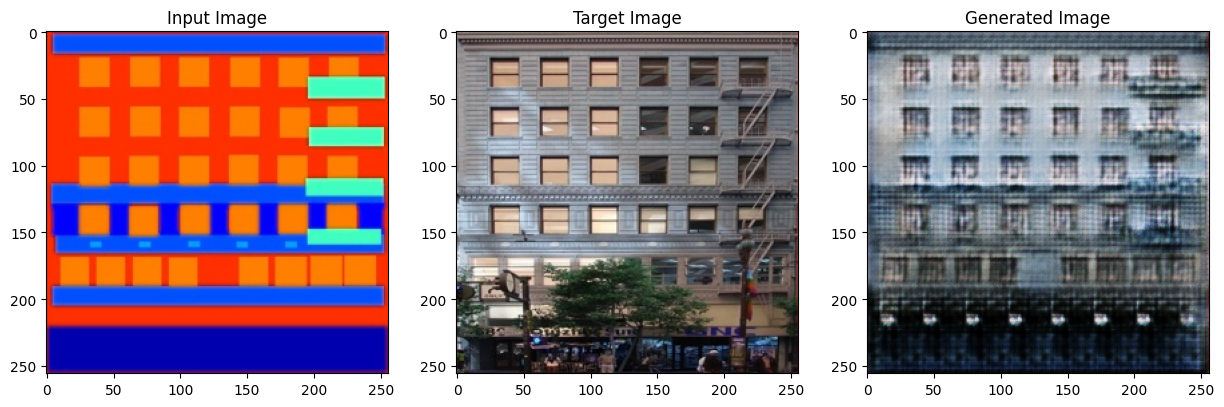

Epoch 10/100 | Generator Loss: 31.3495 | Discriminator Loss: 0.4949


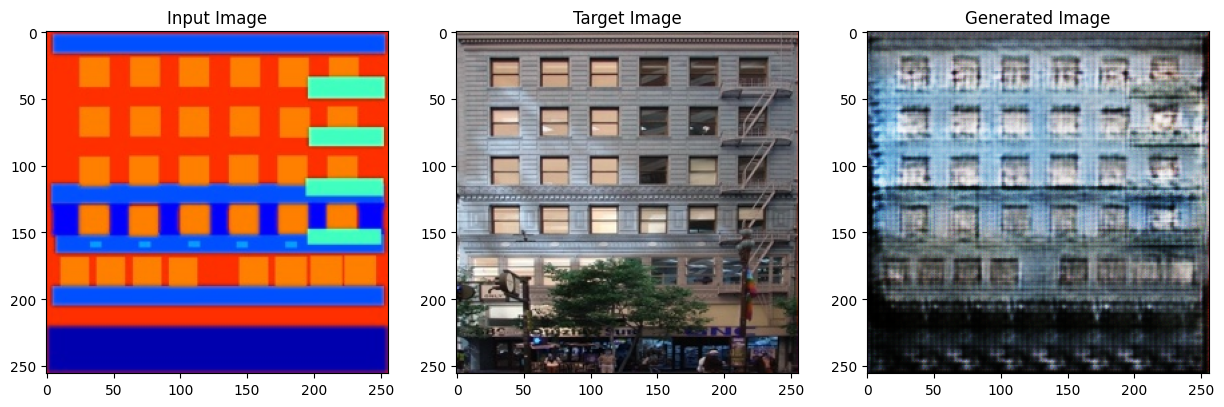

Epoch 20/100 | Generator Loss: 26.4324 | Discriminator Loss: 0.2844


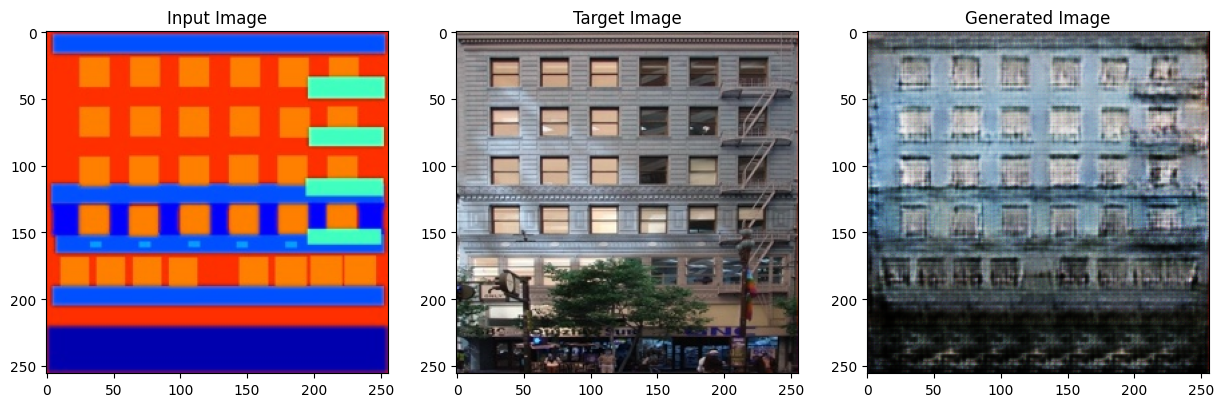

Epoch 30/100 | Generator Loss: 23.2708 | Discriminator Loss: 0.2808


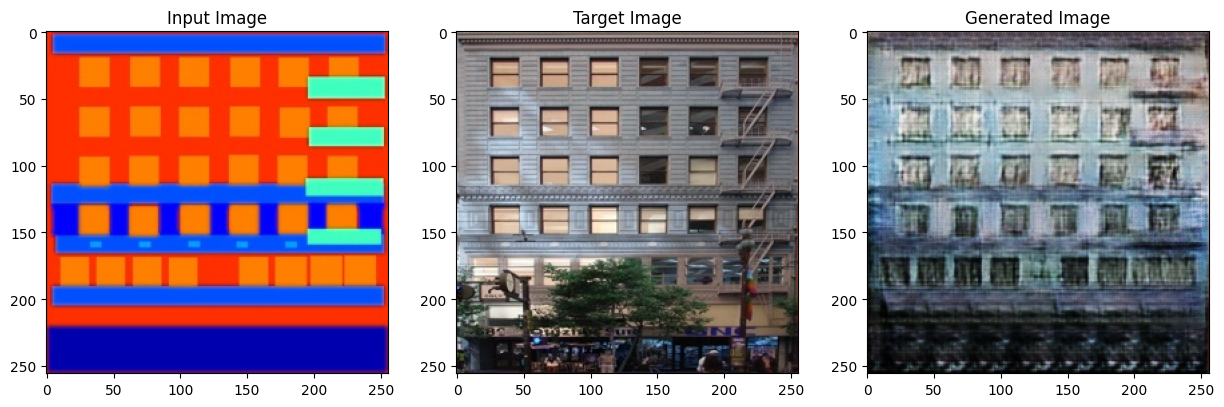

Epoch 40/100 | Generator Loss: 20.1720 | Discriminator Loss: 0.6669


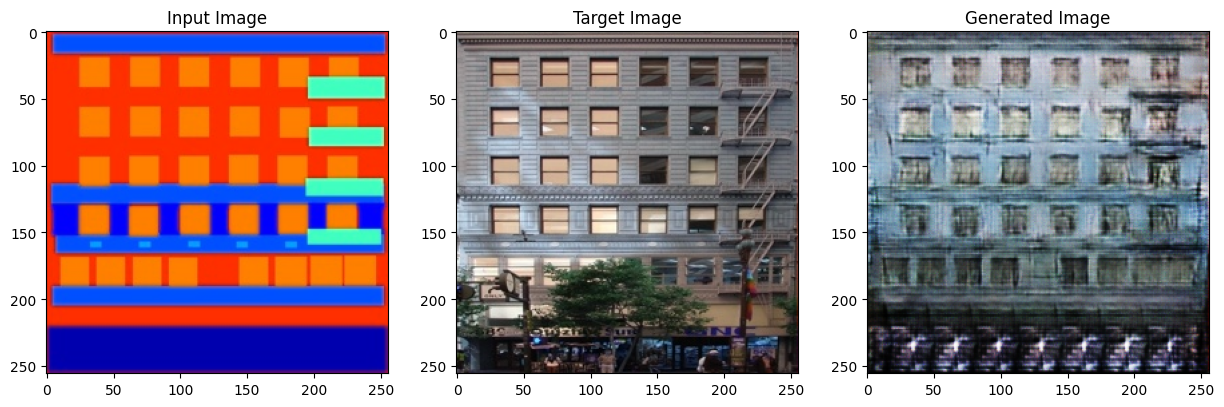

Epoch 50/100 | Generator Loss: 19.0730 | Discriminator Loss: 0.6957


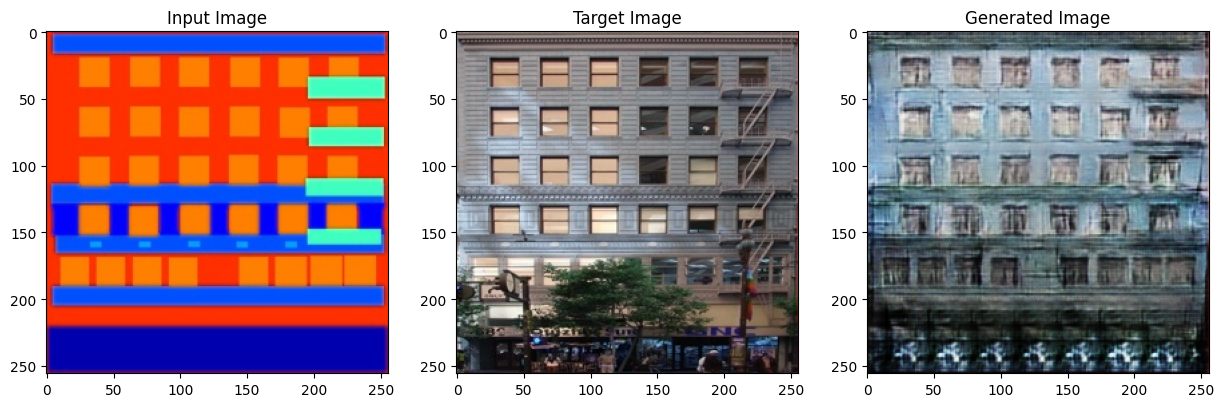

Epoch 60/100 | Generator Loss: 19.5216 | Discriminator Loss: 0.2684


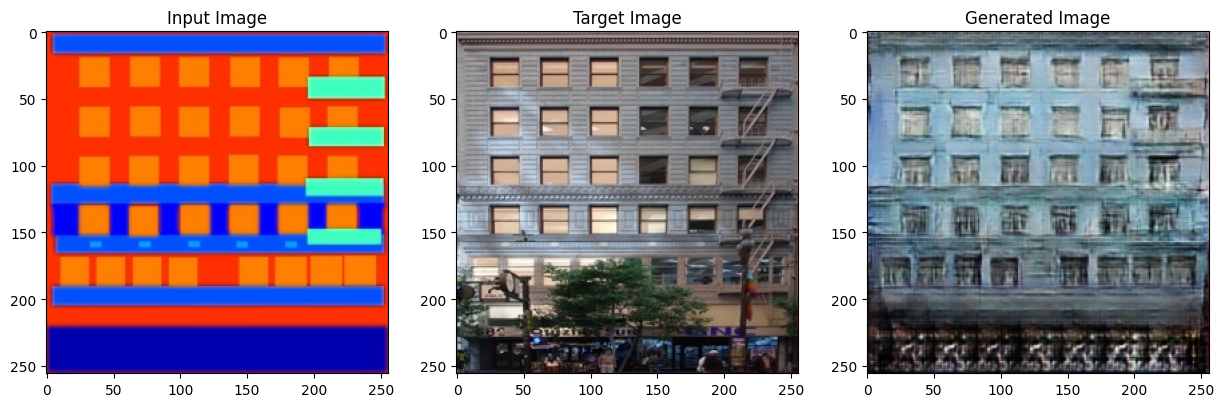

Epoch 70/100 | Generator Loss: 15.3129 | Discriminator Loss: 0.5514


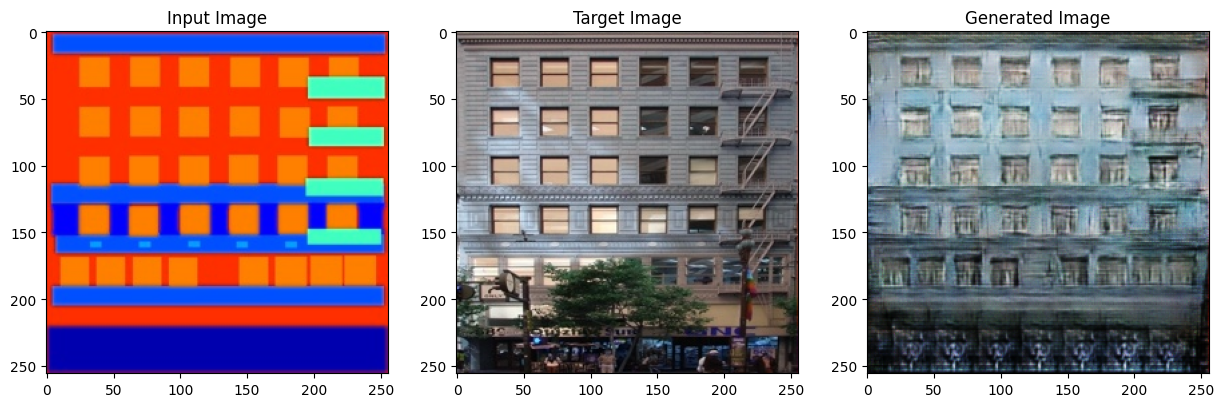

Epoch 80/100 | Generator Loss: 16.0707 | Discriminator Loss: 0.5085


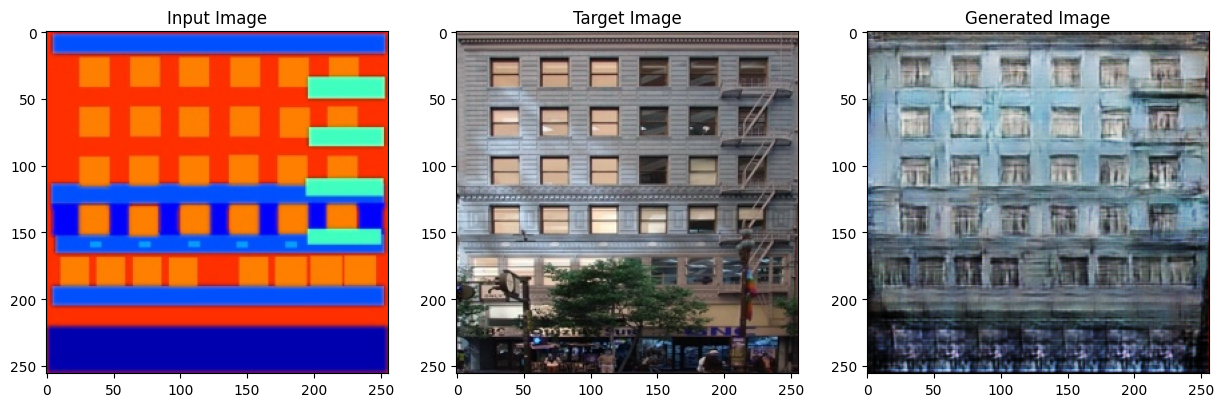

Epoch 90/100 | Generator Loss: 17.5784 | Discriminator Loss: 0.5932


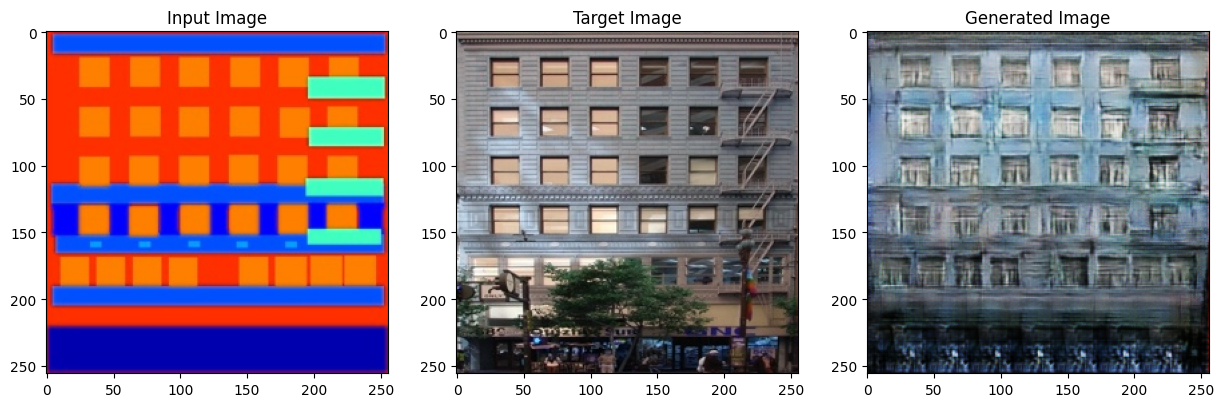

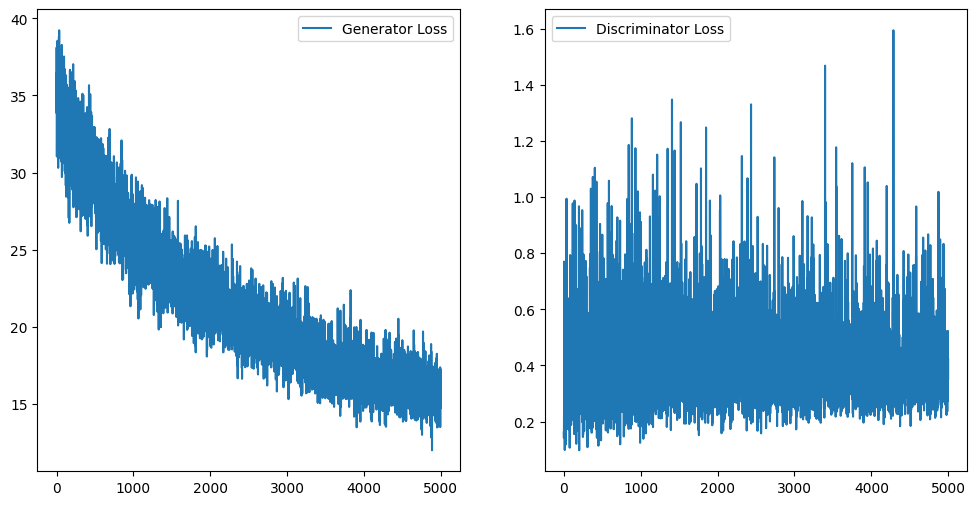

In [35]:
# 학습 시작
num_epochs = 100

generator_losses, discriminator_losses = train(num_epochs, train_loader)

# 학습 결과 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(generator_losses, label='Generator Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.legend()
plt.show()